In [5]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Function to read multiple CSV files from a directory
def read_csv_files(directory):
    dfs = []
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True)


In [9]:
# Read all CSV files for races from the "Races" folder
races = read_csv_files(r"/Users/padhmapriya/Downloads/Races")
# Read all CSV files for horses from the "Horses" folder
horses = read_csv_files(r"/Users/padhmapriya/Downloads/Horses")
# Read the single CSV file for forward data
forward = pd.read_csv(r"/Users/padhmapriya/Downloads/forward.csv")
# Display the first few rows of each dataset
print(races.head())
print(horses.head())
print(forward.head())

/var/folders/xk/9cc213_n6592q_7kpc86xdkc0000gn/T/ipykernel_6101/715653874.py:7: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
/var/folders/xk/9cc213_n6592q_7kpc86xdkc0000gn/T/ipykernel_6101/715653874.py:7: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


      rid          course   time      date  \
0  267255  Southwell (AW)  03:40  97/01/01   
1  297570  Southwell (AW)  12:35  97/01/01   
2  334421  Southwell (AW)  01:05  97/01/01   
3  366304  Southwell (AW)  03:10  97/01/01   
4   13063  Southwell (AW)  02:40  97/01/01   

                                               title   rclass  band   ages  \
0                          New Year Handicap Class E  Class 5  0-70    3yo   
1         Resolution Claiming Stakes Class F (Div I)  Class 6   NaN   4yo+   
2  One Too Many Median Auction Maiden Apprentices...  Class 6   NaN  4-6yo   
3  Morning Call Selling Stakes Class G Southwell ...  Class 6   NaN    3yo   
4           Thinking &amp; Drinking Handicap Class E  Class 5  0-70   4yo+   

  distance condition hurdles                           prizes  winningTime  \
0       1m  Standard     NaN  [2752.25, 833.0, 406.5, 193.25]        106.9   
1       7f  Standard     NaN           [1944.0, 544.0, 264.0]         91.0   
2     1m3f  Standard

Data Cleaning

In [10]:
# Display the first few rows of each dataset
display(races.head())
display(horses.head())
display(forward.head())

,rid,course,time,date,title,rclass,band,ages,distance,condition,hurdles,prizes,winningTime,prize,metric,countryCode,ncond,class,currency
0,267255,Southwell (AW),03:40,97/01/01,New Year Handicap Class E,Class 5,0-70,3yo,1m,Standard,NaN,"[2752.25, 833.0, 406.5, 193.25]",106.9,4184.0,1609.0,GB,0,5,NaN
1,297570,Southwell (AW),12:35,97/01/01,Resolution Claiming Stakes Class F (Div I),Class 6,NaN,4yo+,7f,Standard,NaN,"[1944.0, 544.0, 264.0]",91.0,2752.0,1407.0,GB,0,6,NaN
2,334421,Southwell (AW),01:05,97/01/01,One Too Many Median Auction Maiden Apprentices...,Class 6,NaN,4-6yo,1m3f,Standard,NaN,"[2502.0, 702.0, 342.0]",150.7,3546.0,2212.0,GB,0,6,NaN
3,366304,Southwell (AW),03:10,97/01/01,Morning Call Selling Stakes Class G Southwell ...,Class 6,NaN,3yo,1m,Standard,NaN,"[2189.0, 614.0, 299.0]",108.6,3102.0,1609.0,GB,0,6,NaN
4,13063,Southwell (AW),02:40,97/01/01,Thinking &amp; Drinking Handicap Class E,Class 5,0-70,4yo+,2m½f,Standard,NaN,"[2726.25, 825.0, 402.5, 191.25]",231.4,4144.0,3318.5,GB,0,5,NaN


,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,OR,father,mother,gfather,runners,margin,weight,res_win,res_place,price
0,267255,Going For Broke,3.0,4.0,0.100000,0,P C Haslam,Seb Sanders,1,NaN,...,62.0,Simply Great,Empty Purse,Pennine Walk,6,1.168254,58,1.0,1.0,NaN
1,267255,Pinchincha,3.0,3.0,0.266667,0,Dave Morris,Tony Clark,2,4,...,65.0,Priolo,Western Heights,Shirley Heights,6,1.168254,60,0.0,1.0,NaN
2,267255,Skelton Sovereign,3.0,5.0,0.142857,0,Reg Hollinshead,D Griffiths,3,3,...,60.0,Contract Law,Mrs Lucky,Royal Match,6,1.168254,55,0.0,0.0,NaN
3,267255,Fast Spin,3.0,6.0,0.380952,1,David Barron,Tony Culhane,4,7,...,59.0,Formidable I,Topwinder,Topsider,6,1.168254,57,0.0,0.0,NaN
4,267255,As-Is,3.0,2.0,0.166667,0,Mark Johnston,J Weaver,5,7,...,65.0,Lomond,Capriati I,Diesis,6,1.168254,60,0.0,0.0,NaN


,course,countryCode,marketTime,title,runners,condition,prize,rclass,horseName,trainerName,jockeyName,RPRc,TRc,OR,weightSt,weightLb,age,decimalPrice
0,Limerick,0,2020-09-11 12:45:00+01:00,Irish Stallion Farms EBF Fillies Maiden (Plus ...,14,Yielding To Soft,13717.5,NaN,All Down To Rosie,Conor O'Dwyer,Kevin Manning,NaN,NaN,NaN,9,2,2,50.000000
1,Limerick,0,2020-09-11 12:45:00+01:00,Irish Stallion Farms EBF Fillies Maiden (Plus ...,14,Yielding To Soft,13717.5,NaN,Colfer Kay,K J Condon,W J Lee,79.0,70.0,NaN,9,2,2,6.037778
2,Limerick,0,2020-09-11 12:45:00+01:00,Irish Stallion Farms EBF Fillies Maiden (Plus ...,14,Yielding To Soft,13717.5,NaN,Dha Leath,Garvan Donnelly,J M Sheridan,NaN,NaN,NaN,9,2,2,49.666667
3,Limerick,0,2020-09-11 12:45:00+01:00,Irish Stallion Farms EBF Fillies Maiden (Plus ...,14,Yielding To Soft,13717.5,NaN,Ellabella,Andrew McNamara,Colin Keane,NaN,NaN,NaN,9,2,2,17.944444
4,Limerick,0,2020-09-11 12:45:00+01:00,Irish Stallion Farms EBF Fillies Maiden (Plus ...,14,Yielding To Soft,13717.5,NaN,Fermoy,Mrs John Harrington,Tom Madden,73.0,58.0,NaN,9,2,2,17.594737


In [11]:
# Checking for missing values in races DataFrame
races_missing_values = races.isnull().sum()
print("Missing values in Races DataFrame:")
print(races_missing_values)

Missing values in Races DataFrame:
rid                 0
course              0
time                0
date                0
title               1
rclass         152992
band           231309
ages            13054
distance            0
condition          48
hurdles        274953
prizes              0
winningTime         0
prize           19708
metric              0
countryCode         0
ncond               0
class               0
currency       387291
dtype: int64


In [12]:
# Checking for missing values in horses DataFrame
horses_missing_values = horses.isnull().sum()
print("\nMissing values in Horses DataFrame:")
print(horses_missing_values)


Missing values in Horses DataFrame:
rid                   0
horseName             0
age                 309
saddle           179168
decimalPrice          0
isFav                 0
trainerName        2850
jockeyName          125
position              0
positionL        783662
dist            1074385
weightSt              0
weightLb              0
overWeight      4012988
outHandicap     3994332
headGear        3119695
RPR              864877
TR              1681610
OR              1795263
father             1289
mother             4480
gfather          119374
runners               0
margin                0
weight                0
res_win               0
res_place             0
price           4012304
dtype: int64


In [13]:
# Checking for missing values in forward DataFrame
forward_missing_values = forward.isnull().sum()
print("\nMissing values in Forward DataFrame:")
print(forward_missing_values)



Missing values in Forward DataFrame:
course             11
countryCode         0
marketTime          0
title               0
runners             0
condition           5
prize               0
rclass          10716
horseName           0
trainerName         0
jockeyName         92
RPRc             5597
TRc             10088
OR               9470
weightSt            0
weightLb            0
age                 0
decimalPrice        0
dtype: int64


In [21]:
# Dropping specified columns from races DataFrame
races.drop(columns=['rclass', 'band', 'hurdles', 'currency', 'ages', 'prize'], inplace=True, errors='ignore')

# Dropping specified columns from horses DataFrame
horses.drop(columns=['price', 'headGear', 'TR', 'OR', 'outHandicap', 'overWeight' ,'saddle', 'RPR' , 'dist' , 'positionL' , 'gfather' ,'price'], inplace=True)

# Dropping specified columns from forward DataFrame
forward.drop(columns=['OR', 'TRc', 'RPRc', 'rclass'], inplace=True)

In [22]:
# Calculate the mode of the 'condition' column
mode_condition = races['condition'].mode()[0]

# Fill null values in the 'condition' column with the mode value
races['condition'].fillna(mode_condition, inplace=True)

/var/folders/xk/9cc213_n6592q_7kpc86xdkc0000gn/T/ipykernel_6101/3358997844.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  races['condition'].fillna(mode_condition, inplace=True)


In [23]:
# Fill null values in the 'age' column using mean
mean_age = horses['age'].mean()
horses['age'].fillna(mean_age, inplace=True)

# Fill null values in the specified columns using mode
mode_columns = ['mother', 'father', 'jockeyName', 'trainerName']
for column in mode_columns:
    mode_value = horses[column].mode()[0]
    horses[column].fillna(mode_value, inplace=True)

/var/folders/xk/9cc213_n6592q_7kpc86xdkc0000gn/T/ipykernel_6101/3200140629.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  horses['age'].fillna(mean_age, inplace=True)
/var/folders/xk/9cc213_n6592q_7kpc86xdkc0000gn/T/ipykernel_6101/3200140629.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

In [24]:
# Fill null values in the specified columns using mode
mode_columns = ['course', 'condition', 'jockeyName']
for column in mode_columns:
    mode_value = forward[column].mode()[0]
    forward[column].fillna(mode_value, inplace=True)

/var/folders/xk/9cc213_n6592q_7kpc86xdkc0000gn/T/ipykernel_6101/164072355.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  forward[column].fillna(mode_value, inplace=True)


In [25]:

# Checking for missing values in races DataFrame
races_missing_values = races.isnull().sum()
print("Missing values in Races DataFrame:")
print(races_missing_values)

# Checking for missing values in horses DataFrame
horses_missing_values = horses.isnull().sum()
print("\nMissing values in Horses DataFrame:")
print(horses_missing_values)

# Checking for missing values in forward DataFrame
forward_missing_values = forward.isnull().sum()
print("\nMissing values in Forward DataFrame:")
print(forward_missing_values)


Missing values in Races DataFrame:
rid            0
course         0
time           0
date           0
title          1
distance       0
condition      0
prizes         0
winningTime    0
metric         0
countryCode    0
ncond          0
class          0
dtype: int64

Missing values in Horses DataFrame:
rid             0
horseName       0
age             0
decimalPrice    0
isFav           0
trainerName     0
jockeyName      0
position        0
weightSt        0
weightLb        0
father          0
mother          0
runners         0
margin          0
weight          0
res_win         0
res_place       0
dtype: int64

Missing values in Forward DataFrame:
course          0
countryCode     0
marketTime      0
title           0
runners         0
condition       0
prize           0
horseName       0
trainerName     0
jockeyName      0
weightSt        0
weightLb        0
age             0
decimalPrice    0
dtype: int64


Merge Datasets

In [26]:
# Merge the race and horse datasets on the 'rid' column
merged_data = pd.merge(races, horses, on='rid')

In [27]:
column_names = merged_data.columns
print(column_names)

Index(['rid', 'course', 'time', 'date', 'title', 'distance', 'condition',
       'prizes', 'winningTime', 'metric', 'countryCode', 'ncond', 'class',
       'horseName', 'age', 'decimalPrice', 'isFav', 'trainerName',
       'jockeyName', 'position', 'weightSt', 'weightLb', 'father', 'mother',
       'runners', 'margin', 'weight', 'res_win', 'res_place'],
      dtype='object')


Exploratory Data Analysis (EDA)

In [28]:
# Descriptive statistics
print(merged_data.describe())

                rid   winningTime        metric         class           age  \
count  4.107315e+06  4.107315e+06  4.107315e+06  4.107315e+06  4.107315e+06   
mean   2.079191e+05  1.760163e+02  2.489754e+03  2.521013e+00  4.913815e+00   
std    1.199290e+05  1.039372e+02  1.213905e+03  2.375500e+00  2.246027e+00   
min    0.000000e+00  0.000000e+00  8.040000e+02  0.000000e+00 -1.700000e+01   
25%    1.036025e+05  8.850000e+01  1.407000e+03  0.000000e+00  3.000000e+00   
50%    2.086340e+05  1.314800e+02  2.011000e+03  3.000000e+00  4.000000e+00   
75%    3.117560e+05  2.539000e+02  3.318500e+03  5.000000e+00  6.000000e+00   
max    4.150900e+05  5.552530e+03  7.340500e+03  7.000000e+00  2.700000e+01   

       decimalPrice         isFav      position      weightSt      weightLb  \
count  4.107315e+06  4.107315e+06  4.107315e+06  4.107315e+06  4.107315e+06   
mean   1.175573e-01  1.044334e-01  8.532958e+00  9.237648e+00  6.141118e+00   
std    1.140435e-01  3.058220e-01  9.464667e+00  1.

In [29]:
merged_data.head()

,rid,course,time,date,title,distance,condition,prizes,winningTime,metric,...,position,weightSt,weightLb,father,mother,runners,margin,weight,res_win,res_place
0,267255,Southwell (AW),03:40,97/01/01,New Year Handicap Class E,1m,Standard,"[2752.25, 833.0, 406.5, 193.25]",106.9,1609.0,...,1,9,4,Simply Great,Empty Purse,6,1.168254,58,1.0,1.0
1,267255,Southwell (AW),03:40,97/01/01,New Year Handicap Class E,1m,Standard,"[2752.25, 833.0, 406.5, 193.25]",106.9,1609.0,...,2,9,7,Priolo,Western Heights,6,1.168254,60,0.0,1.0
2,267255,Southwell (AW),03:40,97/01/01,New Year Handicap Class E,1m,Standard,"[2752.25, 833.0, 406.5, 193.25]",106.9,1609.0,...,3,8,11,Contract Law,Mrs Lucky,6,1.168254,55,0.0,0.0
3,267255,Southwell (AW),03:40,97/01/01,New Year Handicap Class E,1m,Standard,"[2752.25, 833.0, 406.5, 193.25]",106.9,1609.0,...,4,9,1,Formidable I,Topwinder,6,1.168254,57,0.0,0.0
4,267255,Southwell (AW),03:40,97/01/01,New Year Handicap Class E,1m,Standard,"[2752.25, 833.0, 406.5, 193.25]",106.9,1609.0,...,5,9,7,Lomond,Capriati I,6,1.168254,60,0.0,0.0


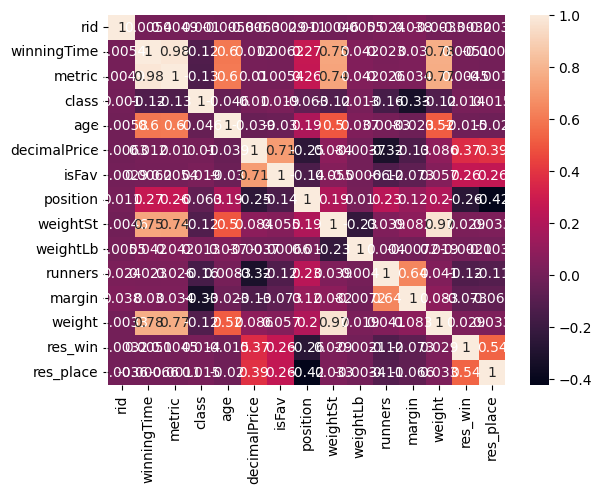

In [32]:
# Exclude non-numeric columns
numeric_columns = merged_data.select_dtypes(include='number')

# Compute correlation matrix
correlation_matrix = numeric_columns.corr()

# Plot heatmap
sns.heatmap(correlation_matrix, annot=True)
plt.show()

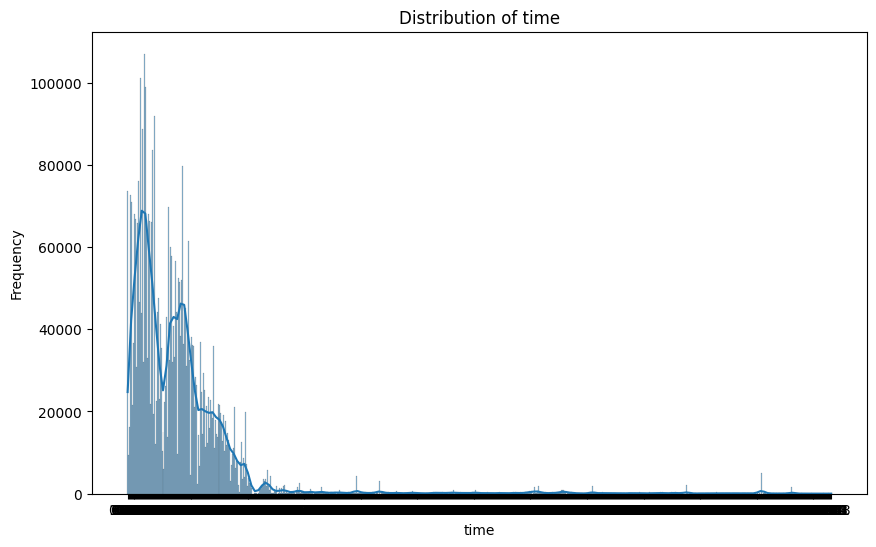

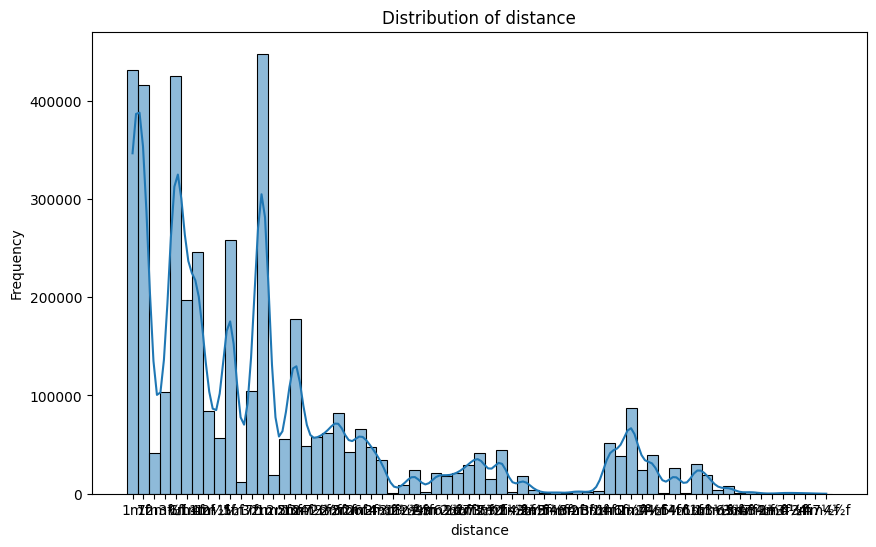

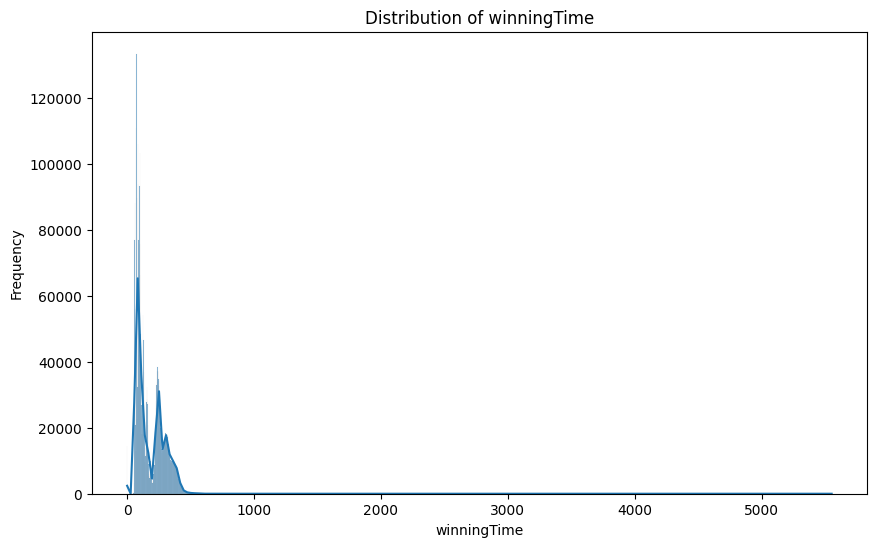

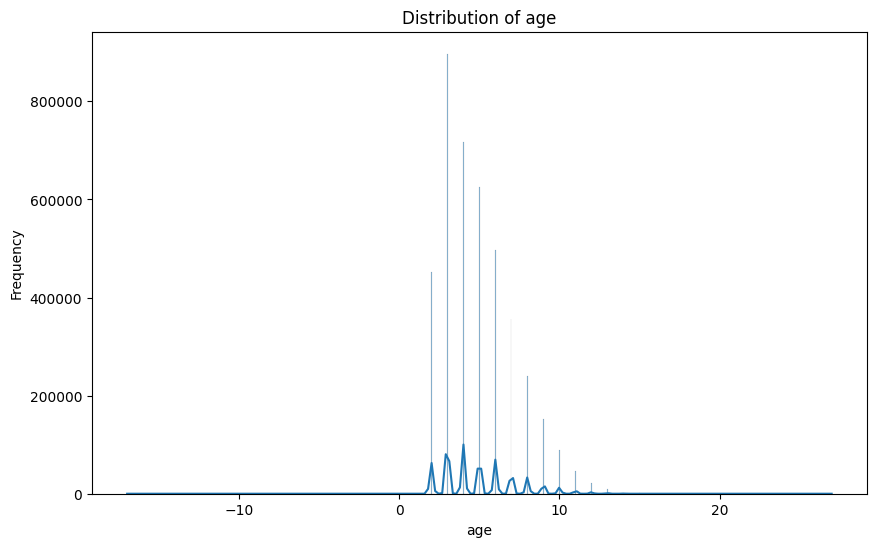

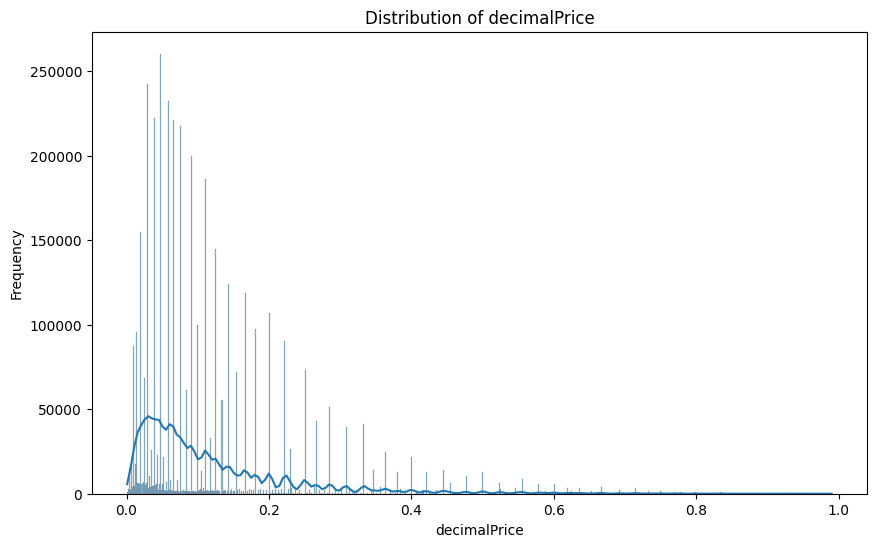

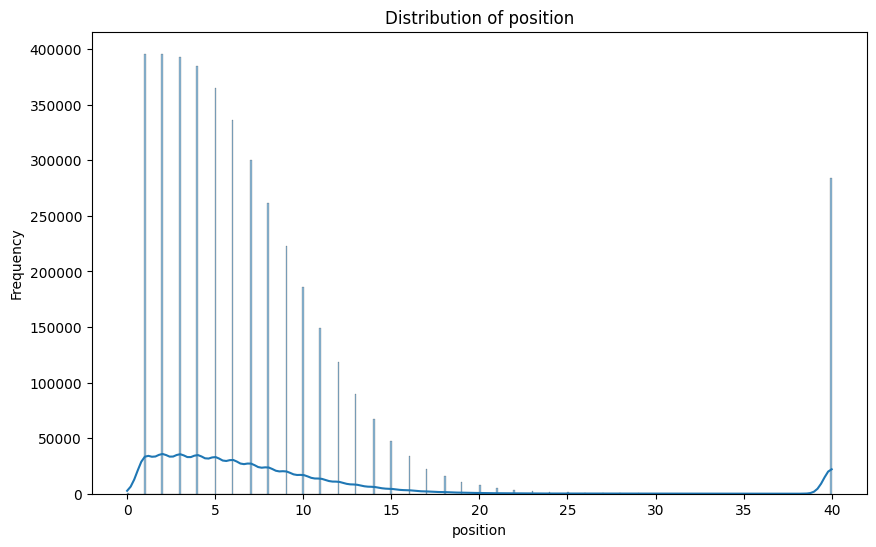

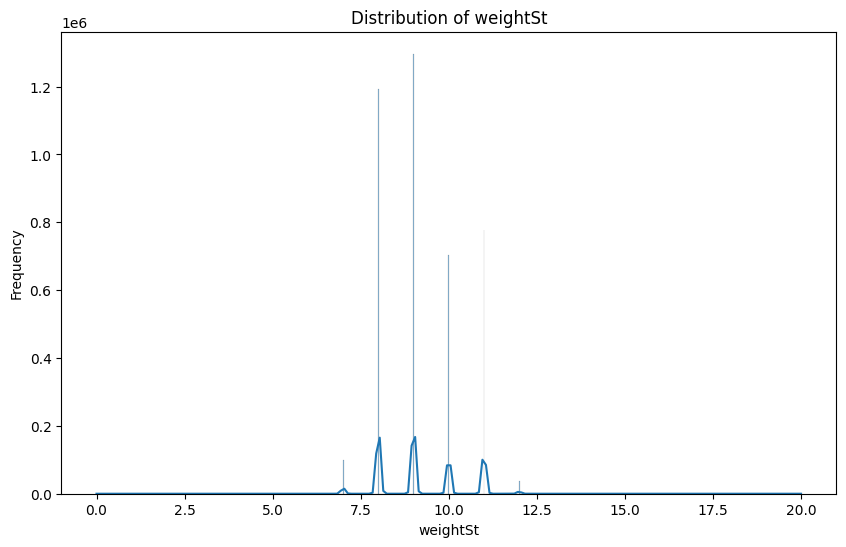

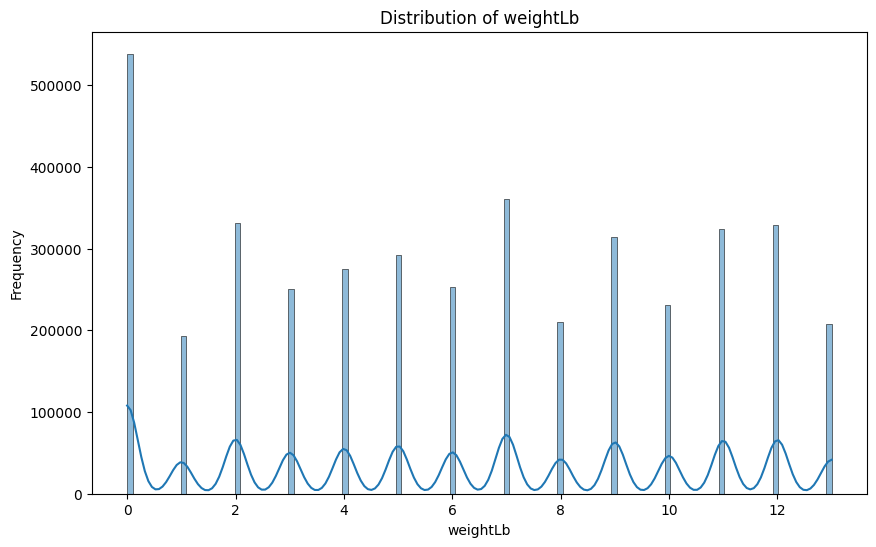

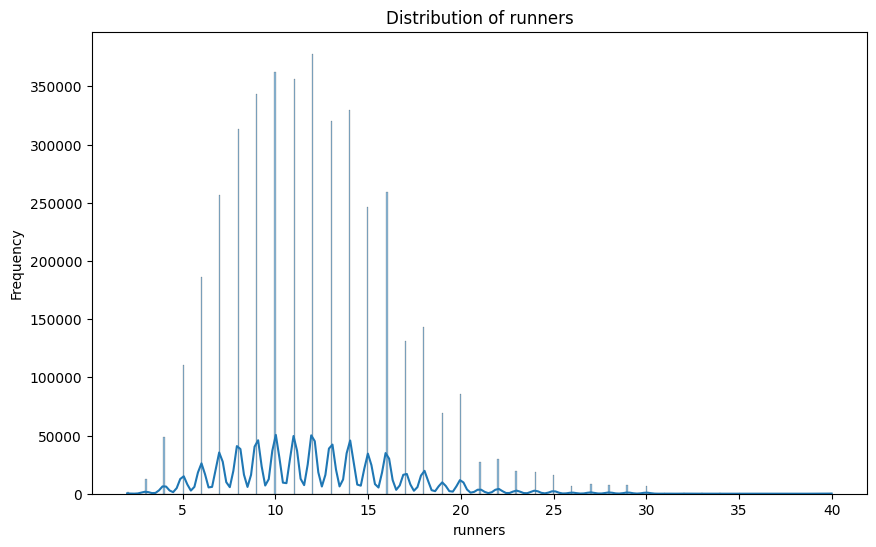

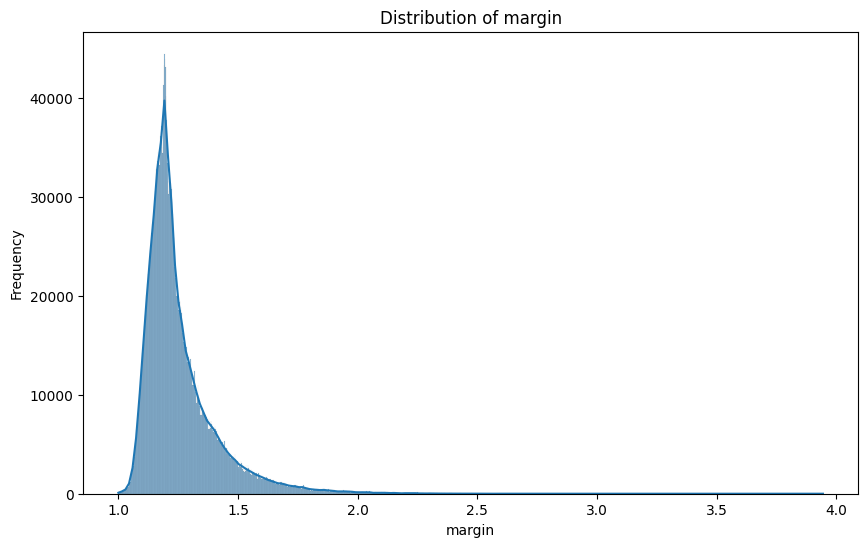

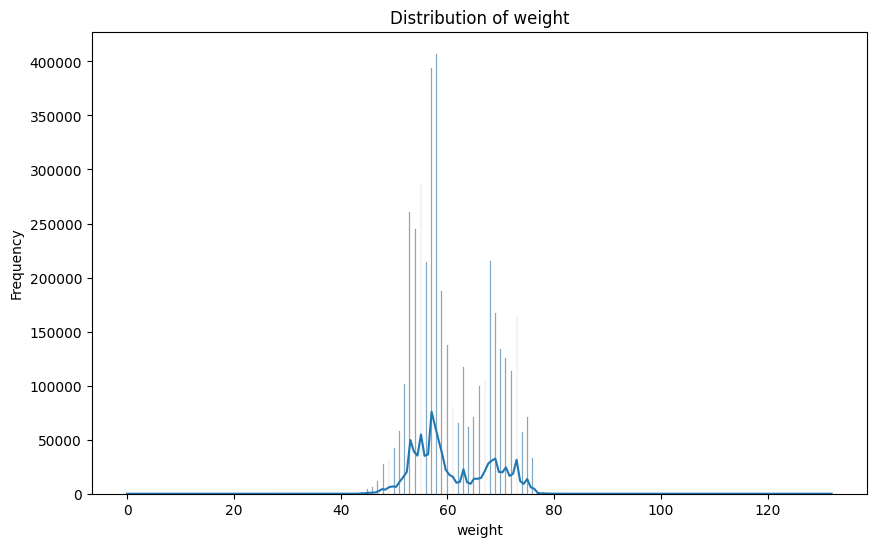

In [33]:
# Assuming merged_data is your DataFrame
continuous_vars = ['time', 'distance', 'winningTime', 'age', 'decimalPrice', 'position', 'weightSt', 'weightLb', 'runners', 'margin', 'weight']

for var in continuous_vars:
    plt.figure(figsize=(10, 6))
    sns.histplot(merged_data[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()

Scatter Plots, Histograms, and Box Plots to Visualize Data Distribution

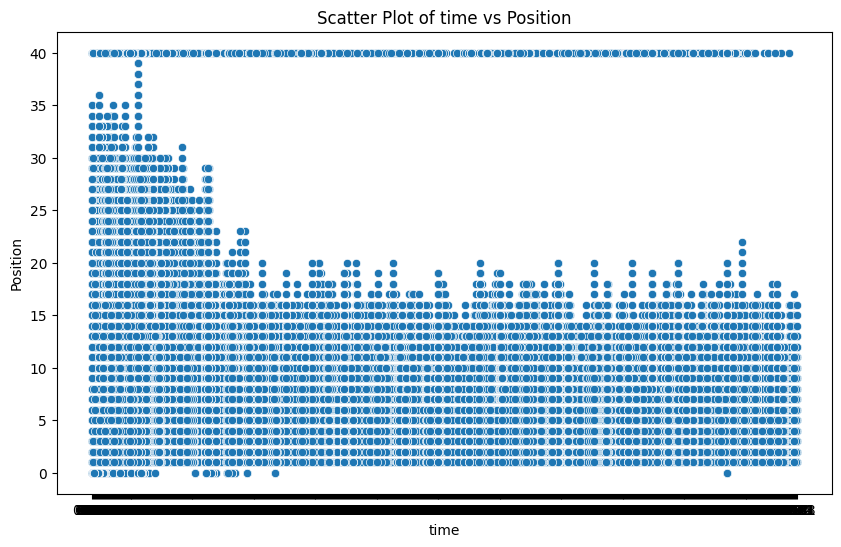

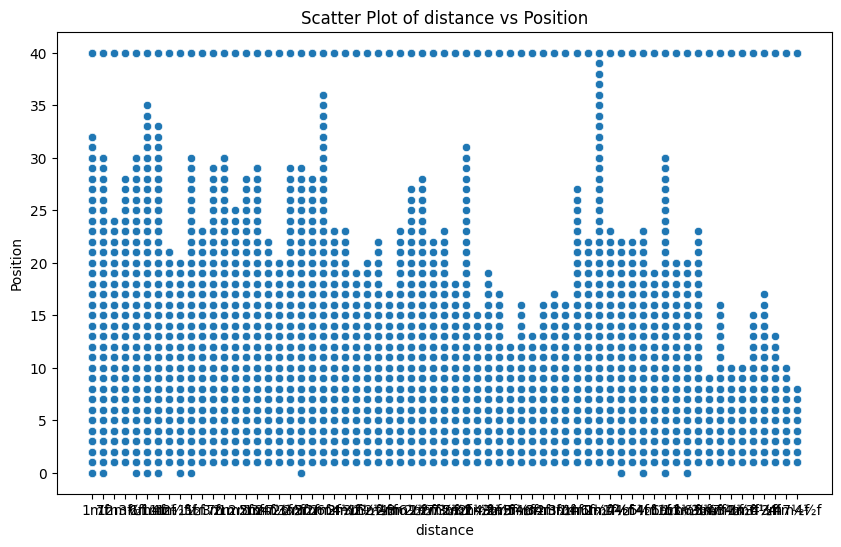

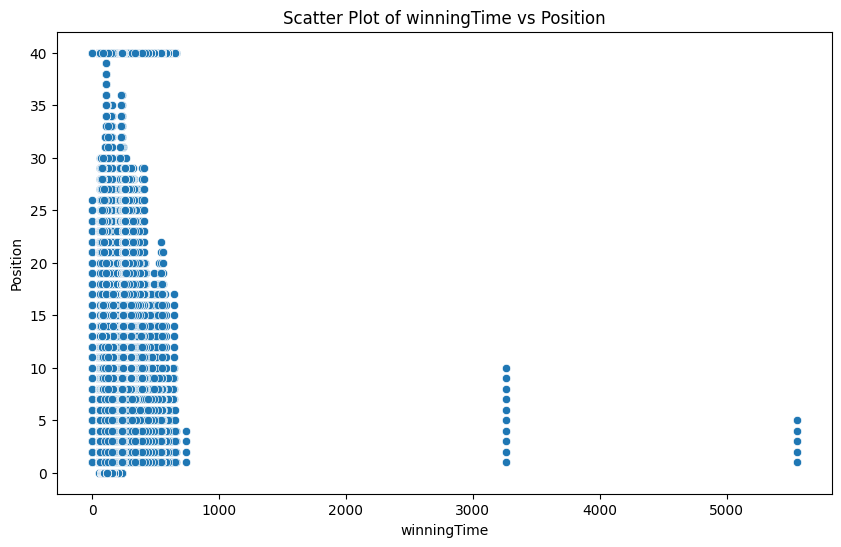

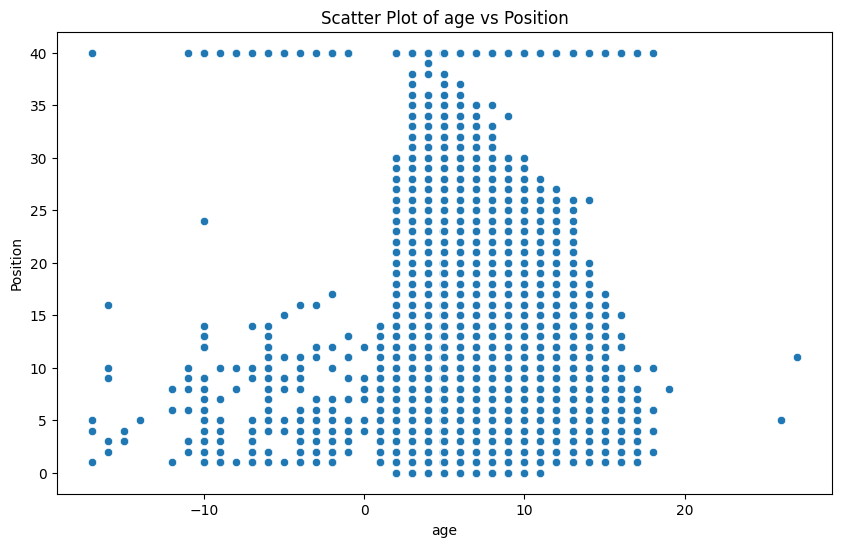

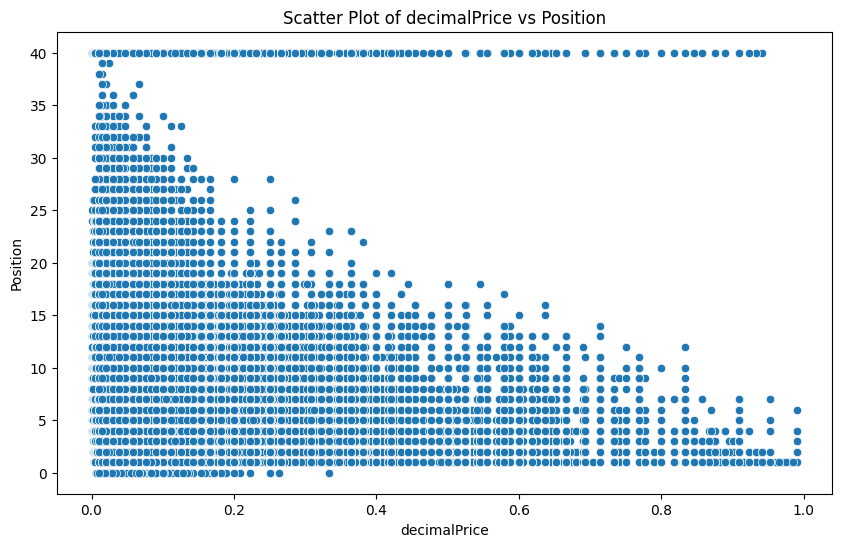

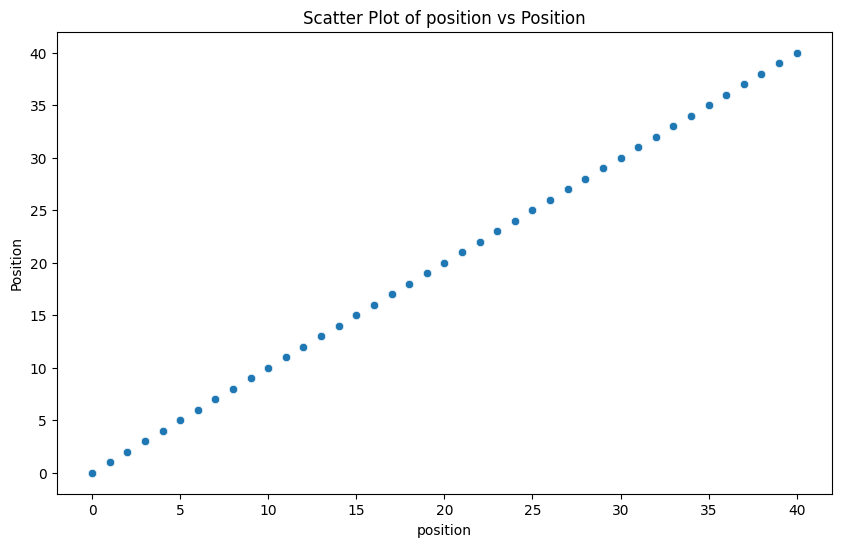

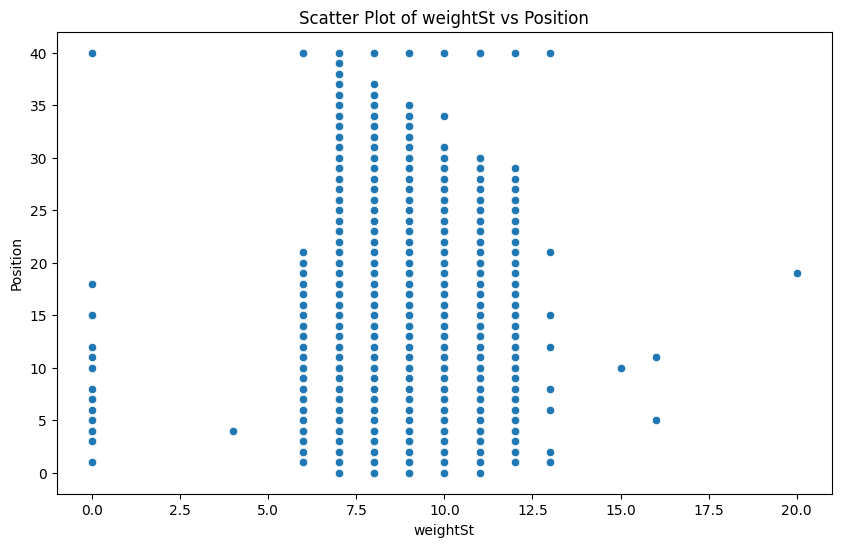

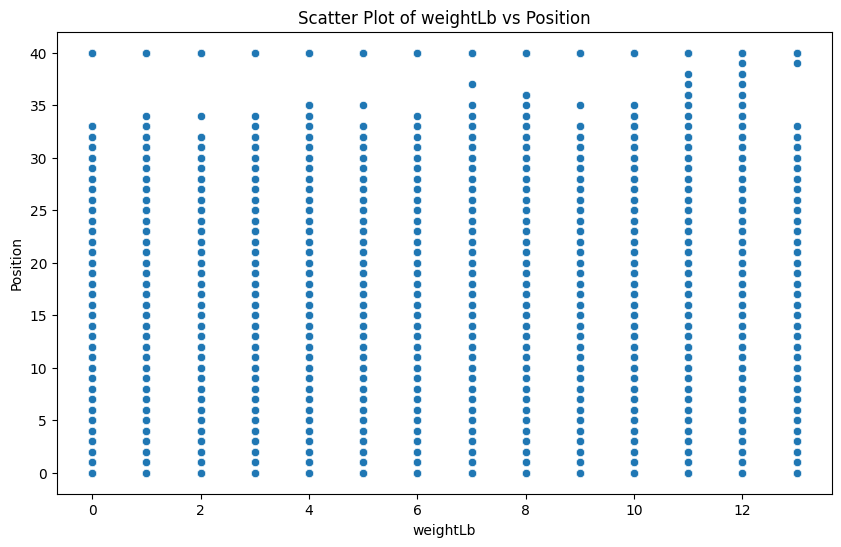

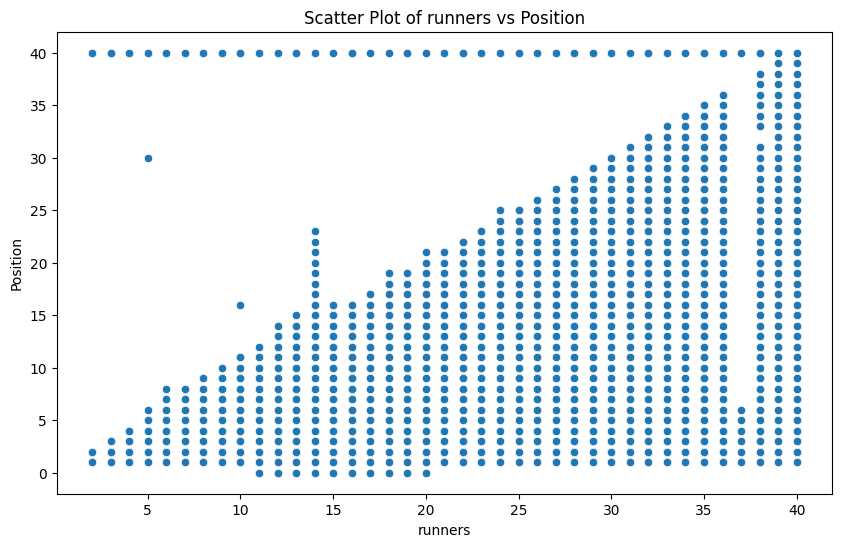

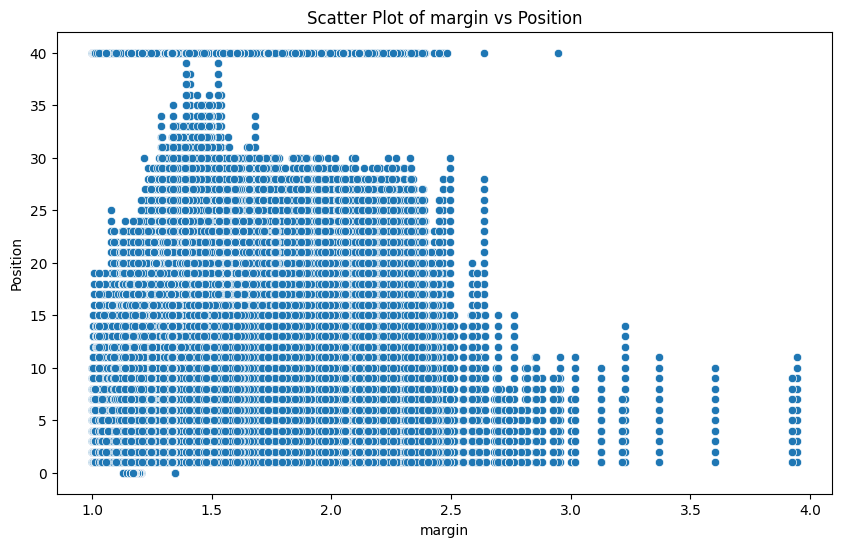

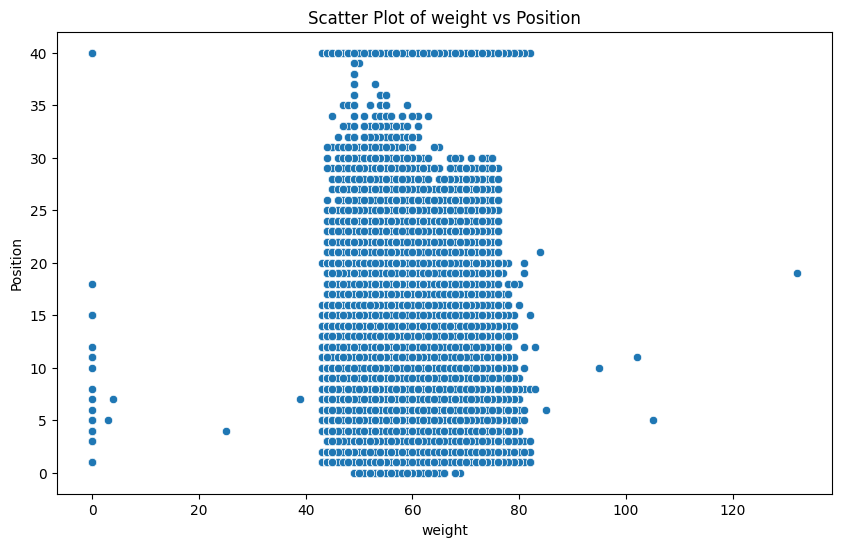

In [34]:
for var in continuous_vars:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=merged_data[var], y=merged_data['position'])
    plt.title(f'Scatter Plot of {var} vs Position')
    plt.xlabel(var)
    plt.ylabel('Position')
    plt.show()

In [35]:
print(merged_data[continuous_vars].dtypes)

time             object
distance         object
winningTime     float64
age             float64
decimalPrice    float64
position          int64
weightSt          int64
weightLb          int64
runners           int64
margin          float64
weight            int64
dtype: object


Split the Data

In [36]:
# Convert 'time' and 'distance' columns to numeric
merged_data['time'] = pd.to_numeric(merged_data['time'], errors='coerce')
merged_data['distance'] = pd.to_numeric(merged_data['distance'], errors='coerce')

In [38]:
# Define continuous variables
continuous_vars = ['time', 'distance', 'winningTime', 'age', 'decimalPrice', 
                   'weightSt', 'weightLb', 'runners', 'margin', 'weight']

# Check for columns with all missing values and remove them
cols_with_all_missing = [col for col in continuous_vars if merged_data[col].isna().all()]
print(f"Columns with all missing values: {cols_with_all_missing}")

# Remove these columns from the continuous_vars list
continuous_vars = [col for col in continuous_vars if col not in cols_with_all_missing]

# Impute missing values with mean strategy
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(merged_data[continuous_vars])
y = merged_data['position']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Columns with all missing values: ['time', 'distance']


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=1)


In [43]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3696583, 8)
X_test shape: (410732, 8)
y_train shape: (3696583,)
y_test shape: (410732,)


In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Train R^2: {train_r2:.4f}")
print(f"Test R^2: {test_r2:.4f}")

Train MSE: 75.1385
Test MSE: 75.4276
Train R^2: 0.1608
Test R^2: 0.1615


In [45]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from scipy.stats import uniform

# Define the parameter grid
param_dist = {
    'fit_intercept': [True, False],  # Whether to calculate the intercept for this model
    'positive': [True, False],       # When set to True, forces the coefficients to be positive
}

# Initialize the model
lr_model = LinearRegression()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(lr_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=1, n_jobs=-1)

# Perform RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = np.sqrt(-random_search.best_score_)

print("Best Parameters:", best_params)
print("Best RMSE:", best_score)

/Applications/anaconda3/anaconda3/envs/myenv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'positive': False, 'fit_intercept': True}
Best RMSE: 8.668276819803438


In [46]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge
import numpy as np

# Define the parameter grid
param_grid = {
    'alpha': np.logspace(-3, 3, 7),  # example values for Ridge regularization strength
    'fit_intercept': [True, False],
    'positive': [True, False]
}

# Initialize the model
model = Ridge()

# Check the total number of parameter combinations
total_combinations = np.prod([len(param_grid[key]) for key in param_grid])
print(f"Total parameter combinations: {total_combinations}")

# Set n_iter to a value <= total_combinations for RandomizedSearchCV
n_iter = min(10, total_combinations)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=n_iter, cv=5, scoring='neg_mean_squared_error', random_state=42)
random_search.fit(X_scaled, y)

# Display best parameters and score
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best RMSE: {np.sqrt(-random_search.best_score_)}")


Total parameter combinations: 28
Best Parameters: {'positive': False, 'fit_intercept': True, 'alpha': 1000.0}
Best RMSE: 8.674754250131588
